#### Урок 6. Сегментация
Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

In [ ]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import random
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_path = r"C:\Users\user\Desktop\temp\Основы нейронных сетей\lesson_6\Water Bodies Dataset\Images\*.jpg"
# image_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg"
mask_path = r"C:\Users\user\Desktop\temp\Основы нейронных сетей\lesson_6\Water Bodies Dataset\Masks\*.jpg"
# mask_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg"
# сортировка по
image_paths = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_paths = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [ ]:
#приводим размер изображения и маски с помощью метода cv2.resize к размеру size
def resize_image(image, size):
    resized_image = cv2.resize(image, size)
    return resized_image

def resize_mask(mask, size):
    # Преобразуйте маску в оттенки серого
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    # изменение размера оттенков серого маски на заданный размер size с использованием метода интерполяции cv2.INTER_NEAREST.
    resized_mask = cv2.resize(mask_gray, size, interpolation=cv2.INTER_NEAREST)
    resized_mask = np.expand_dims(resized_mask, axis=2)
    return resized_mask

In [ ]:
# Задается  размер для изображений и масок
target_size = (128,128)

image_list = []
mask_list = []

for image_path, mask_path in zip(image_paths, mask_paths):
    # Загружается изображение и маска, преобразуются в формат с плавающей запятой (float32) и нормализуются, чтобы значения пикселей находились в диапазоне от 0 до 1.
    image = plt.imread(image_path).astype(np.float32) / 255.
    mask = plt.imread(mask_path).astype(np.float32) / 255.

    # Изменяем размер изображения и маски
    resized_image = resize_image(image, target_size)
    resized_mask = resize_mask(mask, target_size)
    # Измененные изображения и маски добавляются в соответствующие списки image_list и mask_list.
    image_list.append(resized_image)
    mask_list.append(resized_mask)

# Преобразуем списки изображений и масок в массивы
image_array = np.array(image_list)
mask_array = np.array(mask_list)

# контроль формы измененных изображений и массивов масок
print("Форма массива изображений:", image_array.shape)
print("Форма массива масок:", mask_array.shape)


Форма массива изображений: (2841, 128, 128, 3)
Форма массива масок: (2841, 128, 128, 1)


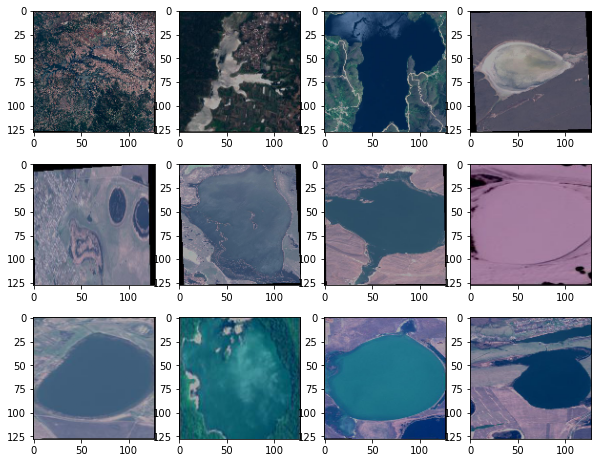

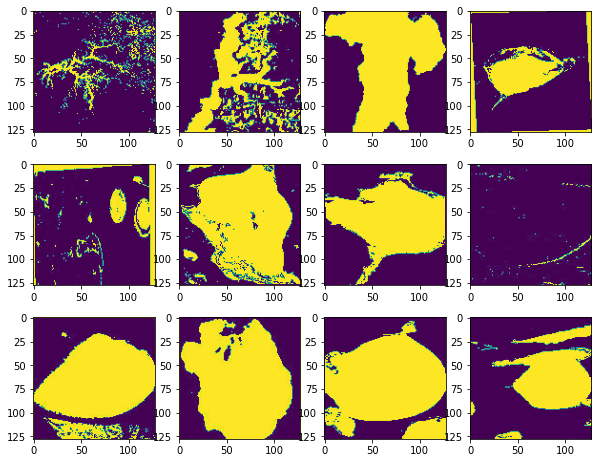

In [ ]:
def show_img(img, nrows=3, ncols=4, figsize=(10, 8)):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  id_img = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i][j].imshow(img[id_img])
      id_img += 1


show_img(image_array)
show_img(mask_array)

In [ ]:
# функция используется для случайного разделения данных на обучающий и тестовый наборы.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_array,mask_array, test_size=0.2, random_state=23)

#### Построение модели U-Net

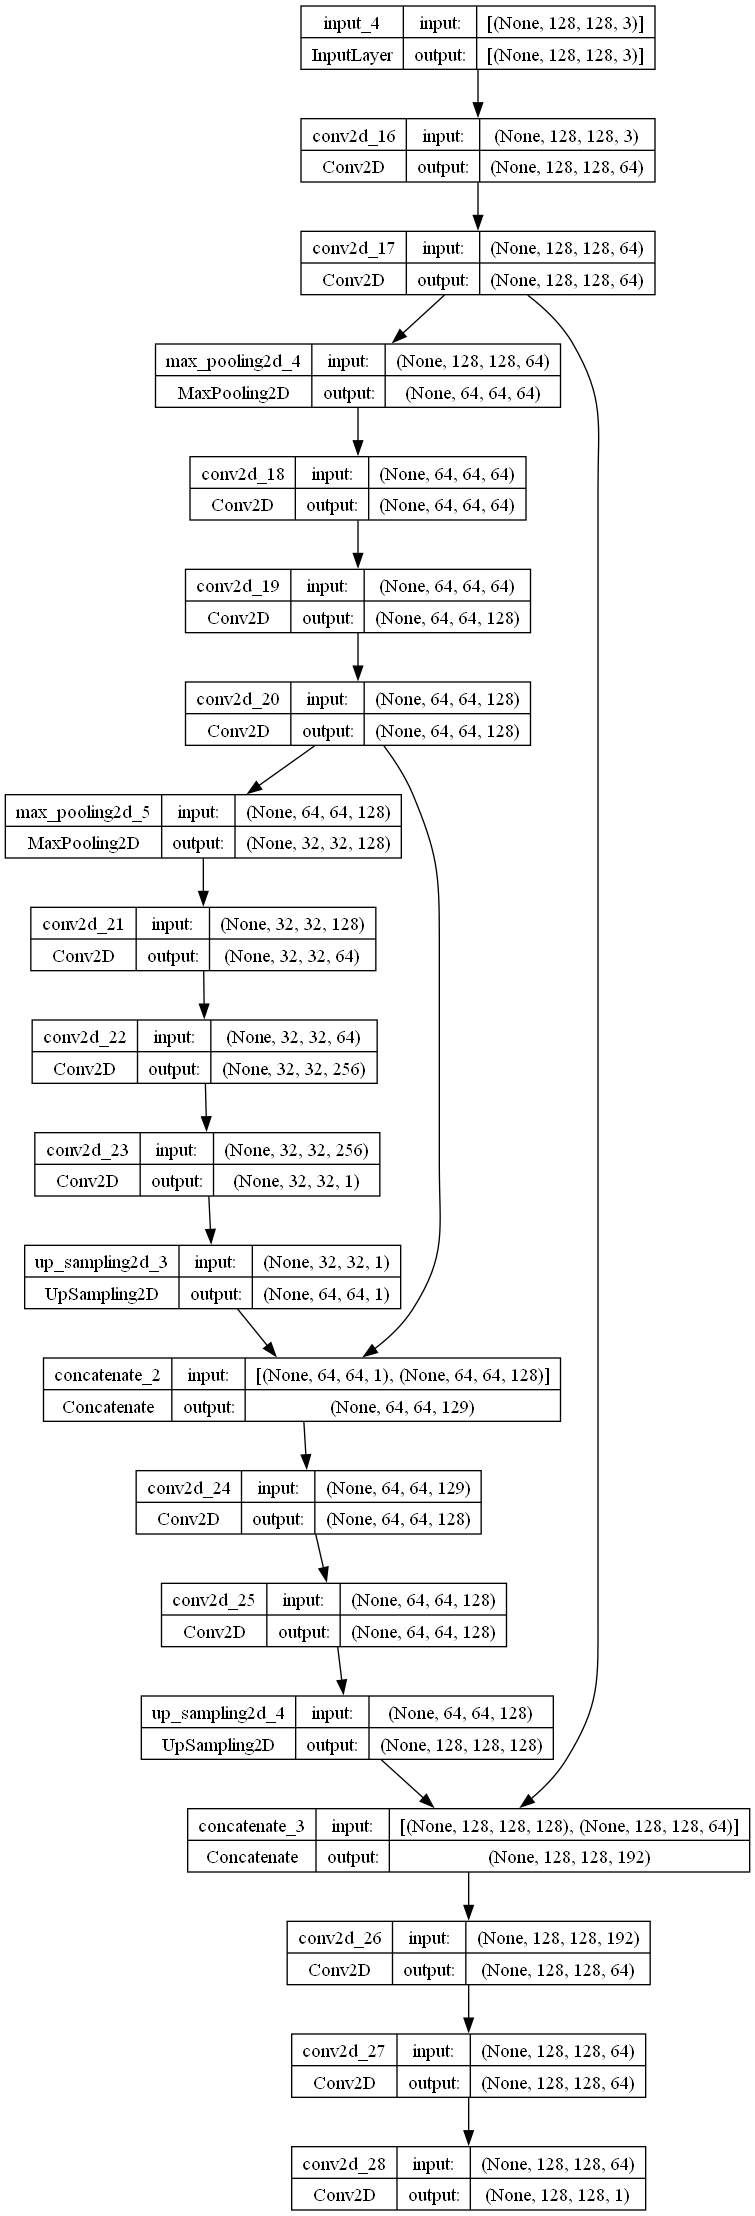

In [ ]:
import tensorflow as tf

# Создаем входной слой с указанием размеров изображений
x = tf.keras.layers.Input((128, 128, 3))

# Encoder
# Создаем слои свертки с указанием количества фильтров, размера ядра и функции активации

enc1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='tanh')(x)
enc2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc1)
# Создаем слой пулинга для уменьшения размера изображения в два раза
enc3 = tf.keras.layers.MaxPooling2D((2, 2))(enc2)
# Добавляем еще слои свертки для увеличения количества фильтров
enc3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='tanh')(enc3)
enc4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc3)
enc5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc4)
# Еще один слой пулинга
enc6 = tf.keras.layers.MaxPooling2D((2, 2))(enc5)
# Добавляем еще слои свертки для увеличения количества фильтров
enc6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='tanh')(enc6)
enc7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc6)
# Добавляем последний слой свертки с одним фильтром и функцией активации relu
enc8 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(enc7)

# Skip connections
# Создаем переменные для пропуска слоев в декодере
skip1 = enc2
skip2 = enc5

# Decoder
# Создаем слой увеличения размера изображения в два раза и добавляем пропущенные слои
dec1 = tf.keras.layers.UpSampling2D((2, 2))(enc8)
dec1 = tf.keras.layers.Concatenate()([dec1, skip2])
# Добавляем еще слои свертки для увеличения количества фильтров
dec1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='tanh')(dec1)
dec1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec1)
# Еще один слой увеличения размера изображения в два раза и добавляем пропущенный слой
dec2 = tf.keras.layers.UpSampling2D((2, 2))(dec1)
dec2 = tf.keras.layers.Concatenate()([dec2, skip1])
dec2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='tanh')(dec2)
dec2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec2)
# Еще один слой увеличения размера изображения в два раза и добавляем последний слой свертки с функцией активации sigmoid
dec3 = tf.keras.layers.UpSampling2D((2, 2))(dec2)
dec3 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(dec2)
# Создаем модель с помощью функции tf.keras.Model() и указываем входной и выходной слой
model = tf.keras.Model(inputs=x, outputs=dec3)

tf.keras.utils.plot_model(model, show_shapes=True)

#### Обучение модели

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Импорт необходимых модулей для обратного вызова EarlyStopping и сохранения лучшей модели с помощью ModelCheckpoint.

model_checkpoint_cb = ModelCheckpoint(r"C:\Users\user\Desktop\temp\Основы нейронных сетей\lesson_6\watermodel.h5",save_best_only=True)
# Определение функции потерь и компиляция модели с помощью оптимизатора 'adam', выбранной функции потерь и метрики 'accuracy'.
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='Adamax', loss=loss, metrics=['accuracy'])
# Обучение модели на данных X_train и y_train с размером пакета 16, на 30 эпохах, используя данные для валидации из X_test и y_test.
history = model.fit(X_train,y_train, batch_size=128, epochs=25,validation_data=(X_test, y_test))

Epoch 1/25
18/18 [==============================] - 474s 26s/step - loss: 0.8644 - accuracy: 0.4800 - val_loss: 0.6437 - val_accuracy: 0.6162
Epoch 2/25
18/18 [==============================] - 472s 26s/step - loss: 0.6079 - accuracy: 0.6273 - val_loss: 0.5552 - val_accuracy: 0.6559
Epoch 3/25
18/18 [==============================] - 471s 26s/step - loss: 0.5251 - accuracy: 0.6721 - val_loss: 0.5102 - val_accuracy: 0.6682
Epoch 4/25
18/18 [==============================] - 464s 26s/step - loss: 0.5204 - accuracy: 0.6793 - val_loss: 0.5028 - val_accuracy: 0.6793
Epoch 5/25
18/18 [==============================] - 474s 26s/step - loss: 0.5020 - accuracy: 0.6900 - val_loss: 0.4847 - val_accuracy: 0.6991
Epoch 6/25
18/18 [==============================] - 475s 26s/step - loss: 0.4959 - accuracy: 0.6936 - val_loss: 0.4716 - val_accuracy: 0.7129
Epoch 7/25
18/18 [==============================] - 467s 26s/step - loss: 0.4843 - accuracy: 0.7070 - val_loss: 0.4603 - val_accuracy: 0.7248
Epoch 

In [ ]:
import pandas as pd

# Создаем словарь с данными
data = {
    'batch': [16,128],
    'epochs': [30,25],
    'optimizer': ['adam','Adamax'],
    'Layer': [10,10],
    'activation': ['sigmoid', 'tanh'],
    'accuracy': [0.8140,0.7760]
}

# Создаем DataFrame из словаря
df = pd.DataFrame(data)

# Выводим таблицу
df

,batch,epochs,optimizer,Layer,activation,accuracy
0,16,30,adam,10,sigmoid,0.814
1,128,25,Adamax,10,tanh,0.776


#### Оценка модели

1/1 [==============================] - 0s 57ms/step


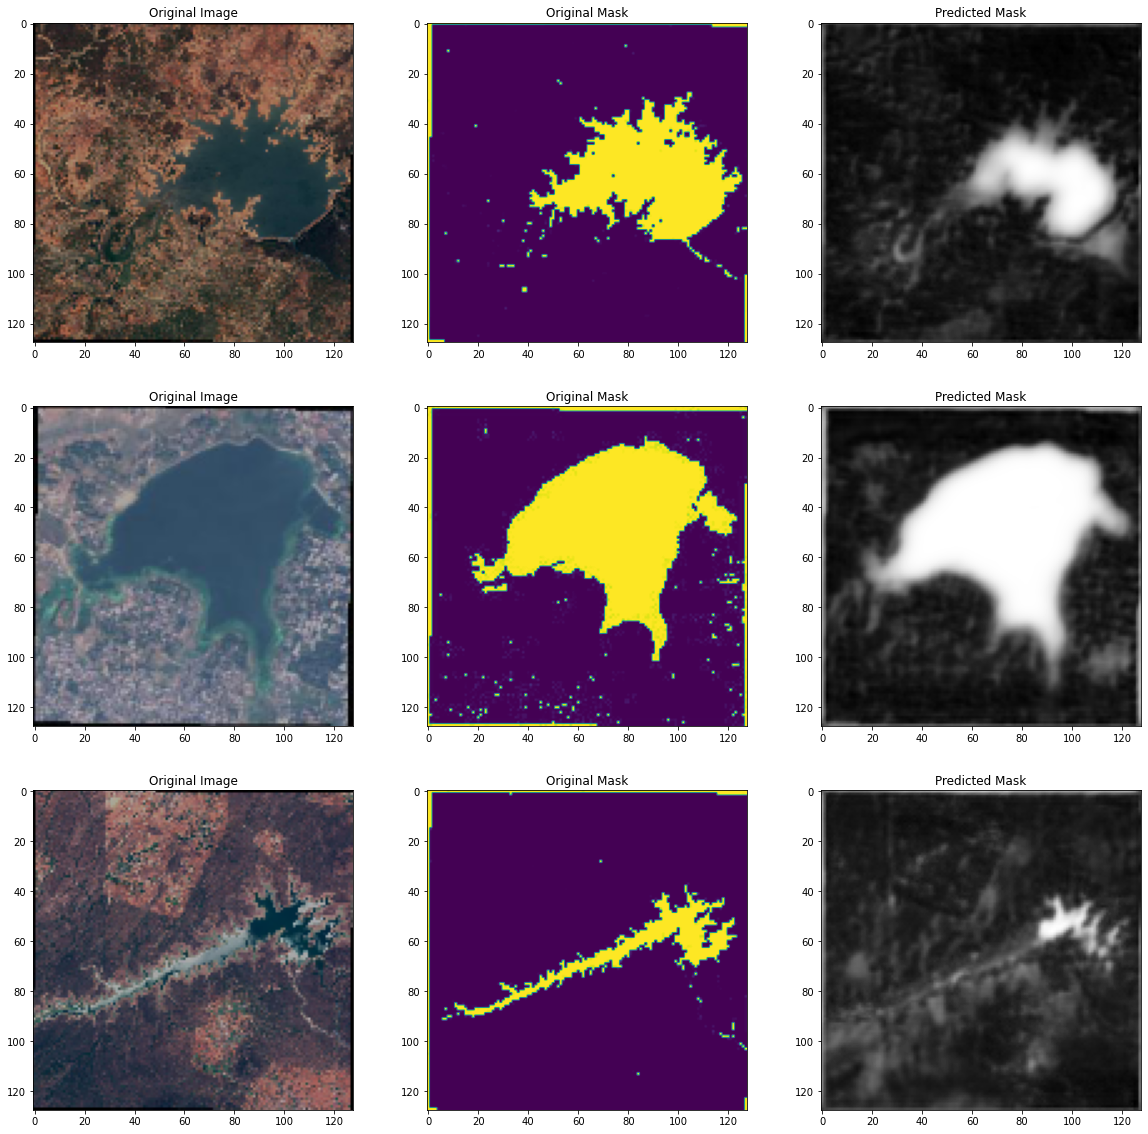

In [ ]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,100)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')

#### Анализ

исследуем влияние различных параметров, таких как размер батча, кол-во итераций, эпох, оптимизатор, количество слоев, функцию активации и значение функции потерь, можно сделать следующие выводы:

1. Первая модель была обучена на пакете данных размером 16, в течение 30 эпох, с использованием оптимизатора Adam. У этой модели 10 слоев и активацией sigmoid. Результатом является достatокеьно высокая точность 0.814.

2. Вторая модель была обучена на пакете данных размером 128, в течение 25 эпох, с использованием оптимизатора Adamax. У этой модели также 10 слоев, но активация тангенс гиперболический. Точность этой модели ниже, равна 0.776.
К сожалению провести большое кол-во замеров не позволяет ресурс компьютора и ограниченность времени.

Из этих результатов можно сделать некоторые предположения:

1. Увеличение размера пакета данных (batch size) может привести к улучшению точности модели. В первом случае точность была выше при значении batch size = 16, в сравнении со значением batch size = 128 во второй модели.
2. У первой модели также было больше эпох для обучения, что также могло сказаться на ее точности. Однако, эффект увеличения числа эпох не всегда приводит к лучшим результатам, поскольку существует риск переобучения модели.
3. Различные оптимизаторы (Adam и Adamax) также могут влиять на точность моделей. В данном случае, первая модель, обученная с использованием оптимизатора Adam, показала лучший результат.
4. Тип активации слоев также может оказывать влияние на точность модели. В первой модели использовалась сигмоидная активация, которая, по всей видимости, лучше подошла для данной задачи.

Таким образом, проведение дополнительных экспериментов с различными значениями batch size, числа эпох, оптимизаторов и активаций может помочь определить наилучшую конфигурацию модели и достичь более высокой точности.